In [1]:
from tensorflow import test
test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/ArXiv_Classifier'
# path = ""

In [4]:
import os
import pickle
import json
from itertools import cycle, product
import pandas as pd

import numpy as np
np.random.seed(123)

from tensorflow import set_random_seed
set_random_seed(123)

from keras.models import Sequential, save_model, load_model
from keras.layers import *
from keras import backend as K
from sklearn.metrics import f1_score

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback

import matplotlib.pyplot as plt
from seaborn import color_palette 
plt.style.use('seaborn')

Using TensorFlow backend.


# Summary

So far the test-data was never used in examining neural nets. Here I'm evaluating the network that proved most promising, the ..., on this data. This is meant as the final evaluation of the *deep-learning* in the project. The obtained score is:

### 81% macro-f1,
which is only marginally higher than the score of the shallow classifiers (by less than one percentage point).

The above score was achieved by a very simple neural network composed of just three layers: the word-embedding, global average-pooling with flattening, and the final dense six-neuron layer with softmax activation.

I have tested also more sophisticated networks, including recurrent nets. But, dissapointingly, the more complicated the network that was used, the worse the learning curves had gotten. So far, my observation is that - for the purpose of maximising the macroF1 score - there is no nuanced, hierarchical, convoluted information is my dataset that would be significant enough to allow the nets to surpass simple classifiers beased on Support-Vector-Machines or Logistical-Regression. Also the nets take much longer to fit.

The one intersting observation is that choice of the loss function is one way to excert some influence over final classfication characteristics, like the macro-precision, f1 and recall, which were of particular interest in this project. 

The steps below are:
* Load in the same constants, parameters, custom functions and the keras-wrapper as before when fittig to the train dataset.
* Use the embedding weights produced in *keras_GlobalAvg_GridSeearch.ipynb* and stored on disk.
* Load in the *train+val* data and, separately the *test* data.
* Fit the architecture to *train+val* with an early-stopping callback.
* Make the final evaluation on *test*.

---
Boilerplate

In [0]:
#! mkdir keras_evaluate_results
working_dir = 'keras_evaluate_results'

In [6]:
global_params = pickle.load(open(os.path.join(path,"global_params.p"), "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404]),
 'n_classes': 6,
 'num_words': 277304,
 'padded_length': 679,
 'unique_words': 277303}

In [7]:
# %run keras_custom_functions.ipynb

notebook1 = '/content/gdrive/My\ Drive/Colab\ Notebooks/ArXiv_Classifier/keras_custom_functions.ipynb'
%run $notebook1

#my_metrics = list(CUSTOM_OBJECTS.values())
my_metrics = ['categorical_accuracy', macroPrec, macroF1, macroRecall]
my_metrics

['categorical_accuracy',
 <function __main__.macroPrec>,
 <function __main__.macroF1>,
 <function __main__.macroRecall>]

In [0]:
#%run keras_plot_history.ipynb
#%run keras_blackbox_wrapper.ipynb

notebook2 = '/content/gdrive/My\ Drive/Colab\ Notebooks/ArXiv_Classifier/keras_plot_history.ipynb'
%run $notebook2

notebook3 = '/content/gdrive/My\ Drive/Colab\ Notebooks/ArXiv_Classifier/keras_blackbox_wrapper.ipynb'
%run $notebook3

---
Embedding weights

In [0]:
embedd_file_crossent = os.path.join(path, 'keras_GlobalAvg_GridSearch_results', 'GlobalAvg_categorical_crossentropy_batch200_nadam_weights.p')
embedd_file_myloss = os.path.join(path, 'keras_GlobalAvg_GridSearch_results', 'GlobalAvg_my_loss_batch200_nadam_weights.p')

---
Train- and validation-data together

In [0]:
X_trainval = np.zeros((700_000, padded_length))
y_trainval = np.zeros((700_000, n_classes))

X_trainval[:500_000, :] = np.load(os.path.join(path, "data", "Kdata", "X_train.npy"))
X_trainval[500_000:, :] = np.load(os.path.join(path, "data", "Kdata", "X_val.npy"))

y_trainval[:500_000, :] = np.load(os.path.join(path, "data", "Kdata", "y_train.npy"))
y_trainval[500_000:, :] = np.load(os.path.join(path, "data", "Kdata", "y_val.npy"))

---
Test data

In [0]:
X_test = np.load(os.path.join(path, "data", "Kdata", "X_test.npy"))
y_test = np.load(os.path.join(path, "data", "Kdata", "y_test.npy"))

---
Epochs, callbacks

Callbacks are monitoring the increase of val_macroF1 and they kick in when it is small (0.005 points). We're first reducing the learning-rate by an order of magnitude (patience=1), and then early-stop (patience=2).

In [0]:
# let's train for
epochs = 10
# with
callbacks = [ReduceLROnPlateau(factor=0.1, monitor='val_macroF1', mode='max', min_delta=5e-3, patience = 1),
            EarlyStopping(monitor='val_macroF1', mode='max', min_delta=5e-3, patience=2)
           ]

---
## Global averaging directly on top of the embedding
Less dropout than when grid-searching and preparing the embedding

In [0]:
layers = [Dropout(0.1), GlobalAveragePooling1D()]

#### loss = *my_loss*

In [17]:
loss, batch_size, optimizer = my_loss, 200, 'nadam'

model_final = BlackBox(tag="GlobalAvg",\
                       layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer,\
                       epochs=epochs, metrics=my_metrics, callbacks=callbacks)

model_final.load_embedd(embedd_file_myloss, trainable=True)
model_final.summary()

loss=my_loss, batch_size=200, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 679, 50)           0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_final.fit(X_trainval, y_trainval, validate_on=(X_test, y_test))
model_final.Ksave()
model_final.save_hist()

loss=my_loss, batch_size=200, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
Train on 700000 samples, validate on 138804 samples
Epoch 1/10
700000/700000 [==============================] - 194s 278us/step - loss: 0.2726 - categorical_accuracy: 0.9339 - macroPrec: 0.7531 - macroF1: 0.7366 - macroRecall: 0.7468 - val_loss: 0.2548 - val_categorical_accuracy: 0.9317 - val_macroPrec: 0.7473 - val_macroF1: 0.7422 - val_macroRecall: 0.7642
Epoch 2/10
700000/700000 [==============================] - 191s 274us/step - loss: 0.2054 - categorical_accuracy: 0.9455 - macroPrec: 0.7988 - macroF1: 0.7970 - macroRecall: 0.8173 - val_loss: 0.2527 - val_categorical_accuracy: 0.9341 - val_macroPrec: 0.7518 - val_macroF1: 0.7418 - val_macroRecall: 0.7592
Epoch 3/10
700000/700000 [==============================] - 202s 289us/step - loss: 0.1902 - categorical_accuracy: 0.9497 - macroPrec: 0.8128 - macroF1: 0.8115 - macroRecall: 0.8298 - val_loss: 0.2525 - val_categorical_accuracy: 0.

*The custom loss function finished in three epochs.*

In [0]:
model_final.load_hist()
model_final.Kload()

Aside from the metrics, I'm plotting the loss function and the learning rate.

loss=my_loss, batch_size=200, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True


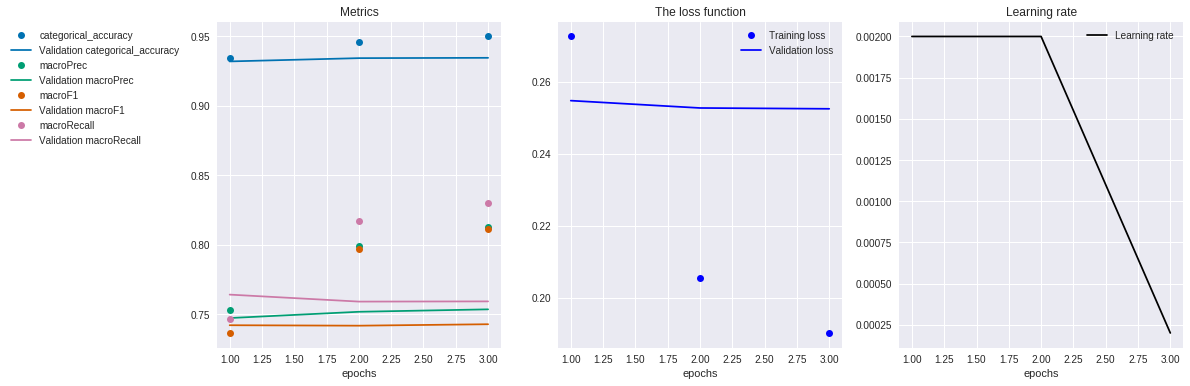

In [25]:
model_final.plot(with_loss=True, with_lr=True)

In [21]:
model_final.evaluate(X_test, y_test)

,GlobalAvg
cat_acc,0.934317
cat_cross,0.316854
macroF1,0.810802
macroPrec,0.804425
macroRecall,0.817515
my_loss,0.194153


---
#### loss = categorical_crosentropy

In [32]:
loss, batch_size, optimizer = 'categorical_crossentropy', 200, 'nadam'

model_second = BlackBox(tag="GlobalAvg",\
                        layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer,\
                        epochs=epochs, metrics=my_metrics, callbacks=callbacks)

model_second.load_embedd(embedd_file_crossent, trainable=True)
model_second.summary()

loss=categorical_crossentropy, batch_size=200, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 679, 50)           0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_second.fit(X_trainval, y_trainval, validate_on=(X_test, y_test))
model_second.Ksave()
model_second.save_hist()

loss=categorical_crossentropy, batch_size=200, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
Train on 700000 samples, validate on 138804 samples
Epoch 1/10
700000/700000 [==============================] - 182s 259us/step - loss: 0.2228 - categorical_accuracy: 0.9259 - macroPrec: 0.6738 - macroF1: 0.6230 - macroRecall: 0.6040 - val_loss: 0.1790 - val_categorical_accuracy: 0.9368 - val_macroPrec: 0.7621 - val_macroF1: 0.7180 - val_macroRecall: 0.7063
Epoch 2/10
700000/700000 [==============================] - 188s 268us/step - loss: 0.1388 - categorical_accuracy: 0.9507 - macroPrec: 0.8051 - macroF1: 0.7675 - macroRecall: 0.7571 - val_loss: 0.1798 - val_categorical_accuracy: 0.9367 - val_macroPrec: 0.7647 - val_macroF1: 0.7202 - val_macroRecall: 0.7091
Epoch 3/10
700000/700000 [==============================] - 194s 277us/step - loss: 0.1231 - categorical_accuracy: 0.9564 - macroPrec: 0.8273 - macroF1: 0.7915 - macroRecall: 0.7810 - val_loss: 0.1804 - val_categori

In [33]:
model_second.load_hist()
model_second.Kload()

Ovewriting the model.


loss=categorical_crossentropy, batch_size=200, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True


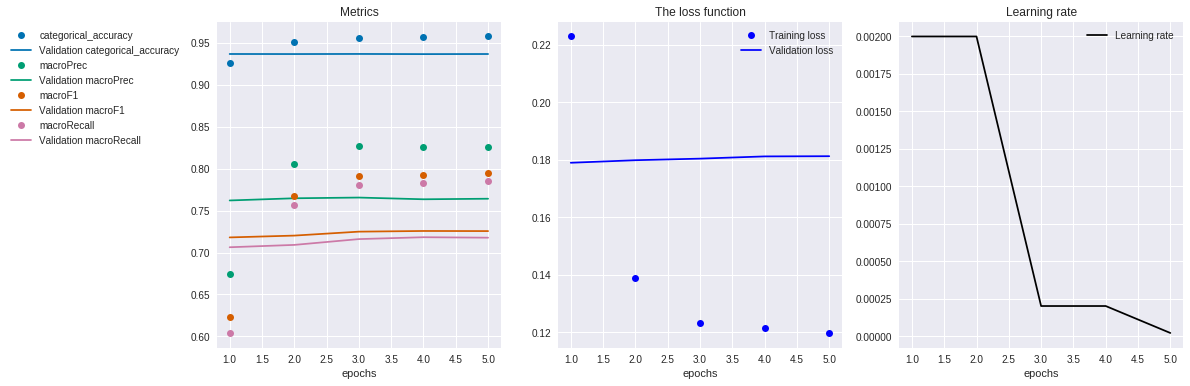

In [34]:
model_second.plot(with_loss=True, with_lr=True)

In [35]:
model_second.evaluate(X_test, y_test)

,GlobalAvg
cat_acc,0.936724
cat_cross,0.181221
macroF1,0.798081
macroPrec,0.838194
macroRecall,0.765180
my_loss,0.234240


---
### End